In [216]:
import numpy.ma as ma
import math
import numpy as np
from netCDF4 import Dataset
from scipy import stats
import networkx as nx
import pandas as pd
import pickle
from scipy import stats
from collections import Counter
from sklearn.metrics.cluster import adjusted_mutual_info_score, mutual_info_score
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, median_absolute_error, mean_absolute_error
import matplotlib.pyplot as plt
from numpy import linspace
from numpy import meshgrid
import pandas as pd
from mpl_toolkits.basemap import Basemap
from matplotlib import animation
import collections


In [121]:
f_pre = Dataset("half_8808.nc")
pr = f_pre.variables['precip']
lat = f_pre.variables['lat']
lon = f_pre.variables['lon']
pr = np.flip(pr, 1)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:238: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return m[indexer]


In [123]:
latvals = lat[:]
lonvals = lon[:]

In [130]:
latvals

array([-50.25, -49.75, -49.25, -48.75, -48.25, -47.75, -47.25, -46.75,
       -46.25, -45.75, -45.25, -44.75, -44.25, -43.75, -43.25, -42.75,
       -42.25, -41.75, -41.25, -40.75, -40.25, -39.75, -39.25, -38.75,
       -38.25, -37.75, -37.25, -36.75, -36.25, -35.75, -35.25, -34.75,
       -34.25, -33.75, -33.25, -32.75, -32.25, -31.75, -31.25, -30.75,
       -30.25, -29.75, -29.25, -28.75, -28.25, -27.75, -27.25, -26.75,
       -26.25, -25.75, -25.25, -24.75, -24.25, -23.75, -23.25, -22.75,
       -22.25, -21.75, -21.25, -20.75, -20.25, -19.75, -19.25, -18.75,
       -18.25, -17.75, -17.25, -16.75, -16.25, -15.75, -15.25, -14.75,
       -14.25, -13.75, -13.25, -12.75, -12.25, -11.75, -11.25, -10.75,
       -10.25,  -9.75,  -9.25,  -8.75,  -8.25,  -7.75,  -7.25,  -6.75,
        -6.25,  -5.75,  -5.25,  -4.75,  -4.25,  -3.75,  -3.25,  -2.75,
        -2.25,  -1.75,  -1.25,  -0.75,  -0.25,   0.25,   0.75,   1.25,
         1.75,   2.25,   2.75,   3.25,   3.75,   4.25,   4.75,   5.25,
      

In [126]:
latvals[21]

-39.75

In [137]:
latvals[26]

-37.25

In [140]:
latvals[181]

40.25

In [30]:
pr.shape

(780, 202, 222)

In [147]:
lonvals[20]

329.75

In [144]:
lonvals[200]

59.75

In [163]:
np.arange(20,202,5).shape

(37,)

In [170]:
np.arange(21,182,5).shape

(33,)

In [191]:
lat

array([-39.75, -37.25, -34.75, -32.25, -29.75, -27.25, -24.75, -22.25,
       -19.75, -17.25, -14.75, -12.25,  -9.75,  -7.25,  -4.75,  -2.25,
         0.25,   2.75,   5.25,   7.75,  10.25,  12.75,  15.25,  17.75,
        20.25,  22.75,  25.25,  27.75,  30.25,  32.75,  35.25,  37.75,
        40.25])

In [192]:
lon

array([-30.25, -27.75, -25.25, -22.75, -20.25, -17.75, -15.25, -12.75,
       -10.25,  -7.75,  -5.25,  -2.75,  -0.25,   2.25,   4.75,   7.25,
         9.75,  12.25,  14.75,  17.25,  19.75,  22.25,  24.75,  27.25,
        29.75,  32.25,  34.75,  37.25,  39.75,  42.25,  44.75,  47.25,
        49.75,  52.25,  54.75,  57.25,  59.75])

In [172]:
int(182/5)

36

In [175]:
len(lat)

33

In [176]:
data = np.zeros((780,33,37))
for i in range(21,182,5):
    for j in range(20,202,5):
        data[:,(int(i/5)-4),(int(j/5)-4)] = pr[:,i,j]

In [177]:
def weighted_matrix(data):
    lat_number = data.shape[1]
    lon_number = data.shape[2]
    N = lat_number * lon_number
    pearson_r = np.zeros((N,N))
    
    for i in range(N):
        lat_index = math.floor(i/lon_number)
        lon_index = i%lon_number
        if ma.is_masked(data[-1,lat_index ,lon_index]): 
            pearson_r[i,:] = np.nan
            continue;
        for j in range(N):
            lat_index_sec = math.floor(j/lon_number)
            lon_index_sec = j%lon_number
            if ma.is_masked(data[-1,lat_index_sec ,lon_index_sec])  or data[-1,lat_index_sec ,lon_index_sec]==-9.96921e+36:
                pearson_r[i,j] = np.nan
            else:
                pearson_r[i,j] = stats.pearsonr(data[:,lat_index ,lon_index],data[:,lat_index_sec ,lon_index_sec])[0]
    
    return(pearson_r)


In [90]:
def graph_builder_limit (weighted_matrix,limit):
    #weighted_matrix = np.exp(-np.sqrt(1 - weighted_matrix))
    weighted_matrix = np.absolute(weighted_matrix)
    componenets_number = 0
    adjacency_matrix = np.zeros(weighted_matrix.shape)
    adjacency_matrix[weighted_matrix >= limit] = 1
    G = nx.from_numpy_matrix(adjacency_matrix)
    G = G.to_undirected()
    G.remove_edges_from(G.selfloop_edges())
    #Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    #componenets_number = len(Gcc) 
    componenets_number = nx.number_connected_components(G)
    return(G, componenets_number)

In [ ]:
def plot_builder(lat,lon,dictionary,centrality_type):
    grid = np.zeros((len(lat),len(lon)))
    lat_number = grid.shape[0]
    lon_number = grid.shape[1]
    for i in range(lat_number):
        for j in range(lon_number):
            index = i * lon_number+j
            if index in dictionary.keys():
                grid[i,j] = dictionary[index]
            else:
                grid[i,j] = np.nan
    
    plt.figure(figsize=(30,15))
    map = Basemap(projection='cyl',
              llcrnrlon=lon[0], 
              llcrnrlat=lat[0], 
              urcrnrlon=lon[-1], 
              urcrnrlat=lat[-1])

    map.drawmapboundary()
    map.drawcoastlines(linewidth=2)
    map.drawcountries(linewidth=2)

    xx, yy = meshgrid(lon, lat)
    cs = map.pcolormesh(xx, yy, grid, cmap=plt.cm.Spectral_r)
    cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)

    
    cbar.set_label(centrality_type)
    
    plt.title('%s Centrality' % (centrality_type), fontsize=16)
    plt.savefig('%s centrality precipitation.eps' % (centrality_type))
    plt.show()
    

In [178]:
weighted_matrix = weighted_matrix(data)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [209]:
G, c = graph_builder_limit(weighted_matrix,0.95)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater_equal
  


In [210]:
N = len(G)
M = G.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

Number of nodes: 1221
Number of edges: 20


In [211]:
lon = np.arange(-30.25,60.75,2.5)
lat = np.arange(-39.75,42,2.5)

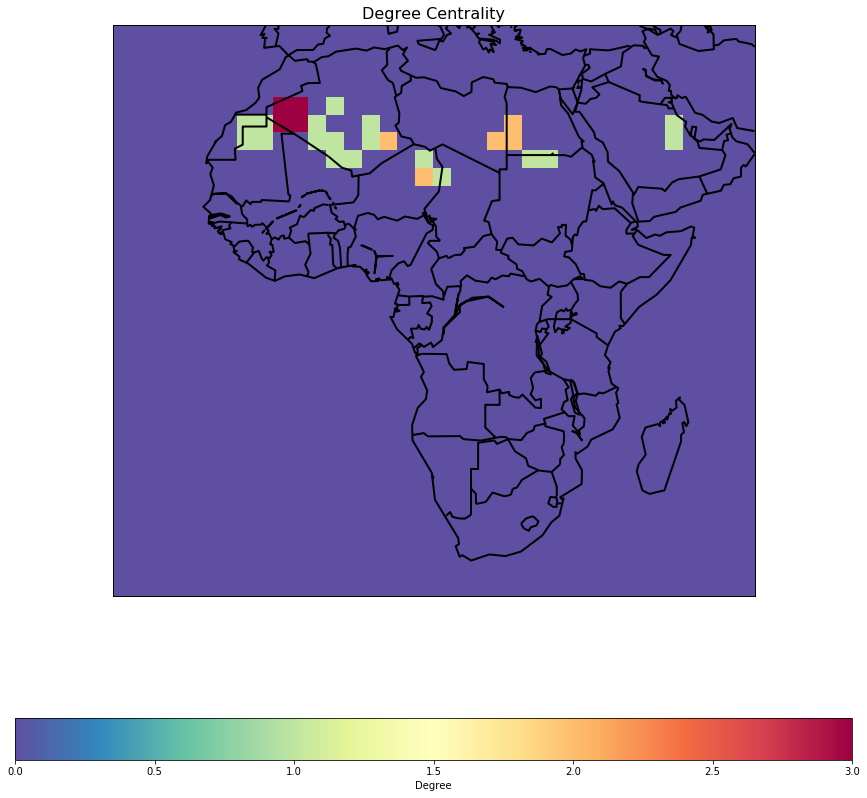

In [212]:
vk = dict(G.degree())
vklist = list(vk.values())
plot_builder(lat,lon,vk,"Degree")

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater_equal
  


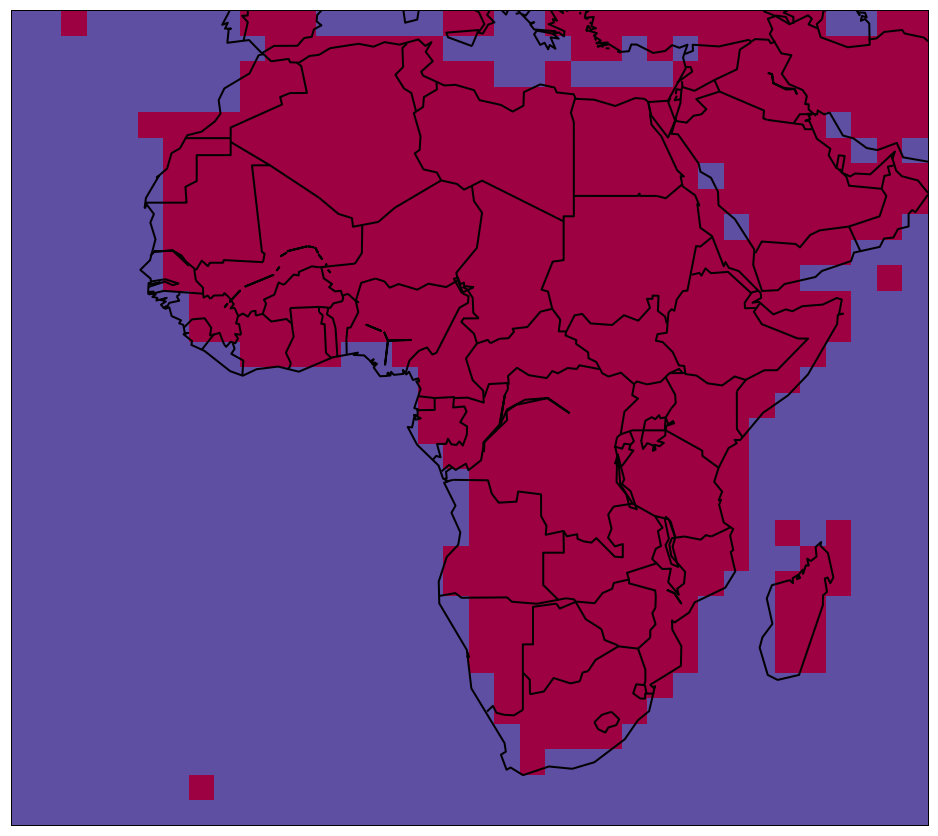

In [223]:
grid = np.zeros((len(lat),len(lon)))
lat_number = grid.shape[0]
lon_number = grid.shape[1]
xx, yy = meshgrid(lon, lat)
fig = plt.figure(figsize=(30,15))
map = Basemap(projection='cyl',
             llcrnrlon=lon[0], 
             llcrnrlat=lat[0], 
             urcrnrlon=lon[-1], 
             urcrnrlat=lat[-1])

map.drawmapboundary()
map.drawcoastlines(linewidth=2)
map.drawcountries(linewidth=2)
#m, p = weighted_matrix(data)
#plt.xlabel("k", fontsize=16)
#plt.ylabel("P(k)", fontsize=16)
#plt.title("Degree Distribution", fontsize=18)

def animate(i): 
   
    G, c = graph_builder_limit(weighted_matrix, 0.01*i)
    
    #vk = dict(G.degree())
    #vk = nx.closeness_centrality(G)
    vk = nx.clustering(G)
    #degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  
    #degreeCount = collections.Counter(degree_sequence)
    #deg, cnt = zip(*degreeCount.items())
    
    for i in range(lat_number):
        for j in range(lon_number):
            index = i * lon_number+j
            if index in vk.keys():
                grid[i,j] = vk[index]
            else:
                grid[i,j] = np.nan
    
    
    #deg = degree_builder(vk, 5)
    #cont = plt.contourf(x, y, z, 25)
    cs = map.pcolormesh(xx, yy, grid, cmap=plt.cm.Spectral_r)
    #cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)

    return cs 

anim = animation.FuncAnimation(fig, animate,frames=100, interval=200)
anim.save('animation_clustering.mp4')

#cs = plt.contourf(xx,yy,deg, cmap=plt.cm.Reds)
#cbar = plt.colorbar(cs, orientation='vertical', shrink=0.5)

#plt.show()

In [8]:
adjusted_mutual_info_score([0.23, 0, 1, 1], [0.15, 0, 1, ])

0.0

In [18]:
f_temp['time'].shape[0]

2558

In [54]:
mutual_info_score(data[:,100,100],data[:,100,105])

6.435123412596658

In [55]:
stats.pearsonr(data[:,100,100],data[:,100,105])[0]

0.77205145

In [4]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [5]:
lon = np.arange(-40.0,72.0,2.5)
lat = np.arange(-50.0,51.0,2.5)
lat_number = len(lat)
lon_number = len(lon)

classes = np.empty([41, 45], dtype="U13")
class_dic = load_obj('class_dic')

for i in range(lat_number):
    for j in range(lon_number):
        latval = i*2.5 - 50
        lonval = j*2.5 - 40
        l = []
        if (latval-0.25,lonval-0.25) in class_dic.keys():
            l.append(class_dic[(latval-0.25,lonval-0.25)])
        if (latval+0.25,lonval+0.25) in class_dic.keys(): 
            l.append(class_dic[(latval+0.25,lonval+0.25)])
        if (latval-0.25,lonval+0.25) in class_dic.keys():
            l.append(class_dic[(latval-0.25,lonval+0.25)])
        if (latval+0.25,lonval-0.25) in class_dic.keys():
            l.append(class_dic[(latval+0.25,lonval-0.25)])
        if len(l) == 0:
            classes[i,j] = np.nan
        else:
            c = Counter(l)
            value,count = c.most_common()[0]
            classes[i,j] = value   

In [6]:
class_dic[(0.25,20.25)]

'Af'

In [6]:
class_dic[(20.25,0.25)]

'BWh'

In [20]:
pr = np.zeros((pr_wtr.shape[0],41,45))
for i in range(0,202,5):
           for j in range(0,222,5):
                lat_index = int((i)/5)
                lon_index = int((j)/5)
                if ma.is_masked(pr_wtr[-1,i,j]) or ma.is_masked(pr_wtr[-1,i,j+1]) or ma.is_masked(pr_wtr[-1,i+1,j]) or ma.is_masked(pr_wtr[-1,i+1,j+1]):
                    pr[:,lat_index,lon_index] = np.nan
                else:
                    pr[:,lat_index,lon_index] = (pr_wtr[:,i,j] + pr_wtr[:,i,j+1] + pr_wtr[:,i+1,j] + pr_wtr[:,i+1,j+1])/4

In [12]:
pr_wtr stats.pearsonr(spi[:,lat_index ,lon_index],spi[:,lat_index_sec ,lon_index_sec])[0]

(780, 202, 222)

In [23]:
def moving_average(series, n):
    return np.mean(series[-n-1:-1])

def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [24]:
p = np.zeros(67)

In [44]:
pr.shape

(780, 41, 45)

In [107]:
lat_number = 41
lon_number = 45

pred3 = []
pred5 = []
pred10 = []
pred1 =[]
pred5 =[]
pred9 =[]
test = []
for i in range(lat_number):
    for j in range(lon_number):
        if not np.isnan(pr[-1,i,j]):
            p = pr[600:779,i,j]
            
            #for z in range(65):
             #   p[z] = np.nanmean(pr[z*12:z*12 + 12, i, j])
            test.append(pr[779,i,j])
            pred3.append(moving_average(p, 3))
            pred5.append(moving_average(p, 5))
            pred10.append(moving_average(p, 10)) 
            pred1.append(exponential_smoothing(p, 0.1)[178])
            pred5.append(exponential_smoothing(p, 0.5)[178])
            pred9.append(exponential_smoothing(p, 0.9)[178]) 

In [112]:
len(pred9)

664

In [117]:
test_score = r2_score(test, pred9)
mae = mean_absolute_error(test, pred9)
mse = mean_squared_error(test, pred9)
d = {'r2 Score':test_score, 'MAE':mae, 'MSE':mse}

In [118]:
d

{'MAE': 36.3858578985387,
 'MSE': 3691.866935222177,
 'r2 Score': 0.436400537330497}

In [99]:
d

{'MAE': 48.63612820840468,
 'MSE': 5728.110646992762,
 'r2 Score': 0.12554809276670287}

In [86]:
resid = np.subtract(test , pred10)
sse = sum(resid**2)
k = 1
AIC= 2*k - 2*math.log(sse)

In [88]:
n = len(test)
BIC = n*math.log(sse/n) + k*math.log(n)

In [89]:
AIC

-28.302846349587217

In [90]:
BIC

5752.18392296008